In [1]:
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import os
import numpy as np
import pandas as pd
import seaborn as sns 
from os import getcwd
from os.path import dirname
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import pickle

In [2]:

# define path
base_path = os.path.dirname(os.getcwd())

# get turku data for plotting 
with open(os.path.join(base_path, 'data', 'neurosynth_results_turku.pkl'), 'rb') as f:
    # load the dictionary from the file
    neurosynth_results_turku = pickle.load(f)

# get enigma data for plotting 
with open(os.path.join(base_path,'data', 'neurosynth_results_enigma.pkl'), 'rb') as f:
    # load the dictionary from the file
    neurosynth_results_enigma = pickle.load(f)

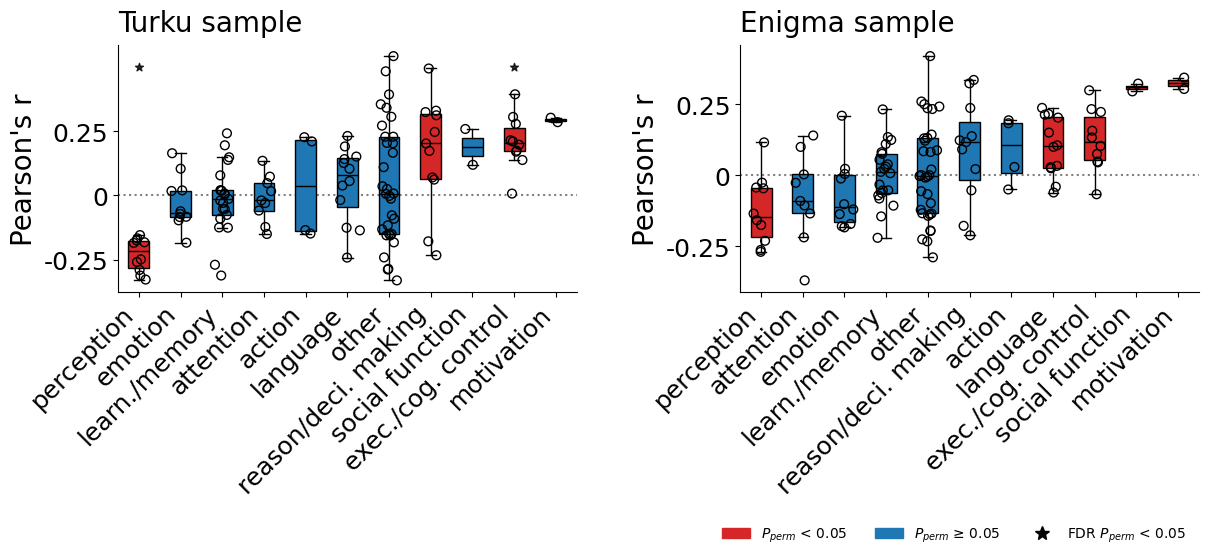

In [4]:
# define function for plotting to reduce code 
def plt_neurosynth(results, ax, title): 
    
    r_categories = results['r_categories']
    order = np.argsort(r_categories)
    r_categories_p = results['r_categories_p']
    p_fdr_ordered = list(np.array(results['r_categories_p_fdr'])[order])
    categories = results['categories']
    categories_labels = results['categories_labels']
    categories_ordered = list(np.array(categories_labels)[order])
    ordered_p = r_categories_p[order]
    ordered_r = r_categories[order]

    rho_all = results['rho']
    r_categories_p = results['r_categories_p']
    r_all_categories = {}
    for i in order:
        r_all_categories[categories_ordered[i]] = rho_all[np.where(categories == i+1)]

    values = list(r_all_categories.values())
    labels = list(r_all_categories.keys())
    
    bp = ax.boxplot(values, 
                     labels=labels,
                     patch_artist=True,
                     showfliers = False,
                     whiskerprops=dict(color='black', linestyle='-'),            
                     medianprops=dict(color='black'),
                     boxprops = dict(linestyle='-', linewidth=1, color='black'));

    for i, data in enumerate(values, start=1):
        y = data
        x = np.random.normal(i, 0.1, size=len(data))
        ax.scatter(x, y, color='none',s=40, edgecolors='black',  linewidth=1, rasterized=True, zorder=1000)

    for i, box in enumerate(bp['boxes']):
        if ordered_p[i] < 0.05 : 
            box.set_facecolor((0.839, 0.152, 0.156))
        else:
            box.set_facecolor((0.121, 0.466, 0.705))

    # plot fdr stars 
    xstars = np.where(np.array(p_fdr_ordered) < 0.05)[0] + 1 
    ystars = np.ones(len(xstars)) * 0.5
    sns.regplot(x=xstars, y=ystars, fit_reg=False, marker="*", color="black", ax=ax )
    
    ax.set_title(title, loc='left', size=20, pad=10.0)
    ax.set(yticks=[-.25, 0, .25])
    ax.set_yticklabels(['-0.25', '0', '0.25'])
    ax.set_ylabel("Pearson's r", fontsize=20)
    ax.tick_params(axis='y', labelsize=18)
    ax.set_xticklabels(categories_ordered, rotation=45, ha="right", fontsize=18);
    ax.grid(False)
    ax.axhline(y=0, color='gray', linestyle=':', zorder=-1)
    ax.set_xticks(np.arange(1, 12, 1))    

# plot 
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

fig, axes = plt.subplots(1,2, figsize=(12, 5))

plt_neurosynth(neurosynth_results_turku, axes[0], 'Turku sample')    
plt_neurosynth(neurosynth_results_enigma, axes[1], 'Enigma sample')    

red_patch = mpatches.Patch(color=(0.839, 0.152, 0.156), label='$P_{perm}$ < 0.05')
blue_patch = mpatches.Patch(color=(0.121, 0.466, 0.705), label='$P_{perm}$ ≥ 0.05')
star = mlines.Line2D([], [], color='black', marker='*', markersize=10, label='FDR $P_{perm}$ < 0.05', linestyle='None')


plt.tight_layout(pad=0.4, w_pad=4.0, h_pad=1.0)
plt.legend(handles=[red_patch, blue_patch, star], bbox_to_anchor=(0.5, -1.4, 0.5, 0.5), frameon = False, ncol=3)

plt.savefig(os.path.join(base_path, 'figures', 'neurosynth_groupings.png'), bbox_inches="tight", dpi=300)


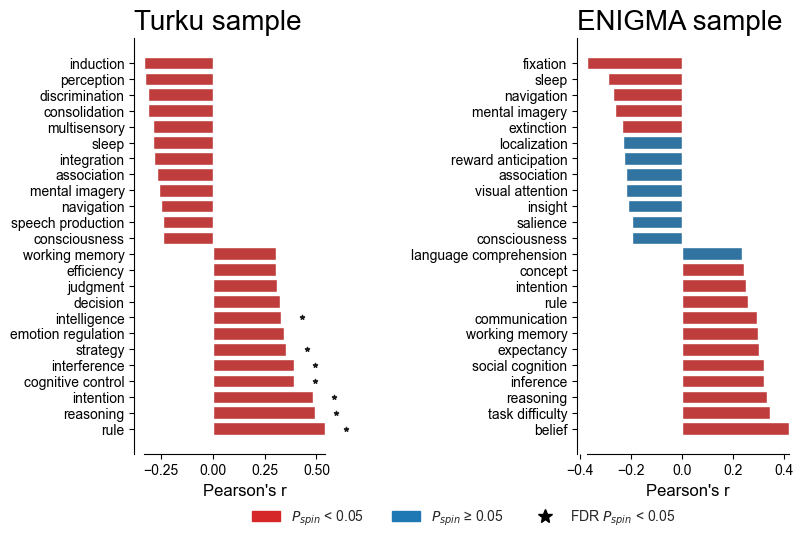

In [5]:
def plot_topbottom(corrs, fig, ax, title):

    df_corrs = pd.DataFrame.from_dict(corrs, orient='index') 
    df_corrs.columns = ['rho', 'pspin']

    _, df_corrs['p_fdr'], _, _ = multipletests(
        df_corrs['pspin'], method='fdr_by')

    # plots 
    sns.set_style("white")

    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False

    df_corrs.index.name = 'terms'
    df_corrs.reset_index(inplace=True)
    df_corrs['terms'] = [i.replace('_', ' ') for i in list(df_corrs['terms'])]
    colors = [(0.839, 0.152, 0.156) if x < 0.05 else (0.121, 0.466, 0.705) for x in df_corrs['pspin']]

    sns.barplot(data=df_corrs, x='rho', y='terms', palette=colors, ax=ax);
    #sns.despine(trim=True)
    # plot fdr 
    ystars = np.where(df_corrs['p_fdr'] < 0.05)[0]
    xstars = np.ones(len(ystars)) * df_corrs['rho'][ystars] + 0.1
    sns.regplot(x=xstars, y=ystars, fit_reg=False, marker="*", color="black",scatter_kws={'s':10}, ax=ax )
    
    ax.set(ylabel = None)
    ax.set_title(title, loc='left', size=20)
    ax.set_xlabel("Pearson's r", fontsize=12)
    ax.spines['bottom'].set_bounds(df_corrs['rho'].min(), df_corrs['rho'].max())
    
corrs_turku_ns = dict(np.load(os.path.join(base_path, 'data', 'corrs_turku_neurosynth_tb.npz')))
corrs_enigma_ns = dict(np.load(os.path.join(base_path, 'data', 'corrs_enigma_neurosynth_tb.npz')))

fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(8,5))
plot_topbottom(corrs_turku_ns, fig, axes[0], 'Turku sample')
plot_topbottom(corrs_enigma_ns, fig, axes[1], 'ENIGMA sample')
plt.tight_layout(pad=0.4, w_pad=4.0, h_pad=1.0); 

red_patch = mpatches.Patch(color=(0.839, 0.152, 0.156), label='$P_{spin}$ < 0.05')
blue_patch = mpatches.Patch(color=(0.121, 0.466, 0.705), label='$P_{spin}$ ≥ 0.05')
star = mlines.Line2D([], [], color='black', marker='*', markersize=10, label='FDR $P_{spin}$ < 0.05', linestyle='None')
plt.legend(handles=[red_patch, blue_patch, star], loc='best', bbox_to_anchor=(0, -0.6, 0.5, 0.5), frameon = False, ncol=3)

plt.savefig(os.path.join(base_path, 'figures','neurosynth_topbottom_terms.png'), bbox_inches="tight", dpi=300)
